In [1]:
!pip -V

pip 23.3.1 from /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/pip (python 3.10)


# .init

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import os
import sys
from pathlib import Path
workspace_dir = Path.cwd()
if not (workspace_dir / '.git').exists():
    workspace_dir = workspace_dir.parent


module_path = str(workspace_dir.resolve()) # os.path.abspath(os.path.join('..'))
print(f'workspace dir: {module_path}')

# Fixes a periodic issue with locating local packages.
if module_path not in sys.path:
    sys.path.append(module_path)

workspace dir: /root/feature-map-experiments


In [8]:
import openslide
slides_dir = workspace_dir / 'WSI'
slide_path = slides_dir / 'C-16-098.svs'

print(f'{slide_path}')
slide = openslide.OpenSlide(str(slide_path))

'/root/feature-map-experiments/WSI/C-16-098.svs'

/root/feature-map-experiments/WSI/C-16-098.svs



(process:95684): Openslide-WARNING **: 03:52:34.975: Downsampled images not correctly ordered: 1 < 64.0115


OpenSlideUnsupportedFormatError: Unsupported or missing image file

In [9]:
# Получаем размеры изображения
width, height = slide.level_dimensions[0]
print(f'{width=} {height=}')

patch_size = 224


NameError: name 'slide' is not defined

In [10]:
import pyvips

left = 10
top = 10
width = 64
height = 64

image = pyvips.Image.new_from_file(str(slide_path))
roi = image.crop(left, top, width, height)
print('average:', roi.avg())


(process:95684): Openslide-WARNING **: 04:10:59.939: Downsampled images not correctly ordered: 1 < 64.0115


Error: unable to call VipsForeignLoadOpenslideFile
  openslide2vips: unsupported slide format


In [11]:
!pip list | grep vips


pyvips                    2.2.3


In [30]:
import slideio

slide = slideio.open_slide(str(slide_path),'SVS')
num_scenes = slide.num_scenes
scene = slide.get_scene(0)
print(f'{num_scenes=}, {scene.name=}, {num_scenes=}, {scene.rect=}, {scene.num_channels=}, {scene.resolution=}, {scene.magnification}')

num_scenes=1, scene.name='Image', num_scenes=1, scene.rect=(0, 0, 153384, 81672), scene.num_channels=3, scene.resolution=(2.5219999999999994e-07, 2.5219999999999994e-07), 40.0


In [13]:
raw_string = slide.raw_metadata
raw_string.split("|")

['Aperio Image Library v12.0.15 \r\n156464x81772 [0,100 153384x81672] (240x240) JPEG/RGB Q=70',
 'AppMag = 40',
 'StripeWidth = 2032',
 'ScanScope ID = SS7543',
 'Filename = C-16-098',
 'Date = 06/23/21',
 'Time = 00:15:17',
 'Time Zone = GMT+09:00',
 'User = 36624229-2cba-4aa8-a149-ebdb6adf0861',
 'Parmset = MK1',
 'MPP = 0.2522',
 'Left = 16.534300',
 'Top = 22.633415',
 'LineCameraSkew = -0.000800',
 'LineAreaXOffset = 0.015493',
 'LineAreaYOffset = -0.010352',
 'Focus Offset = 0.000000',
 'ImageID = 1042670',
 'Exposure Time = 45',
 'Exposure Scale = 0.000001',
 'DisplayColor = 0',
 'SessonMode = NR',
 'BestFocusLayer = 1',
 'OriginalWidth = 156464',
 'OriginalHeight = 81772',
 'ICC Profile = ScanScope v1',
 'TotalDepth = 1.000000']

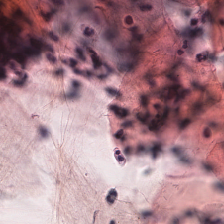

In [37]:

from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

# image = scene.read_block((5000, 5000, 5000, 5000), size=(500,0))
image = scene.read_block((39000, 39000, 500, 500), size=(224,0))

# plt.imshow(image)
Image.fromarray(image).convert('RGB').show()

In [40]:
def extract_patches_from_slide(scene: slideio.Scene, start, patch_size, step):
    """
    Извлекает патчи из изображения заданного размера и с заданным шагом по x и y.

    :param slide: slideio.Scene
    :param patch_size: Размер патча (ширина, высота).
    :param step_x: Шаг по горизонтали.
    :param step_y: Шаг по вертикали.
    :return: Двумерная матрица патчей (numpy array).
    """
    patches = []
    width, height = (scene.rect[2], scene.rect[3])
    patch_width, patch_height = patch_size

    step_x, step_y = step

    start_x, start_y = start

    for y in range(start_y, height - patch_height + 1, step_y):
        row_patches = []
        for x in range(start_x, width - patch_width + 1, step_x):
            patch = scene.read_block((x, y, patch_width, patch_height), size=(224,0))
            # patch = image.crop((x, y, x + patch_width, y + patch_height))
            row_patches.append(np.array(patch))
        patches.append(row_patches)

    return np.array(patches)

In [41]:
p = extract_patches_from_slide(scene, (39000, 39000), patch_size=(224,224), step=(224,224))

KeyboardInterrupt: 

In [ ]:
p.shape